In [1]:
import pickle as pkl
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import sys

import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import tensorflow as tf

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


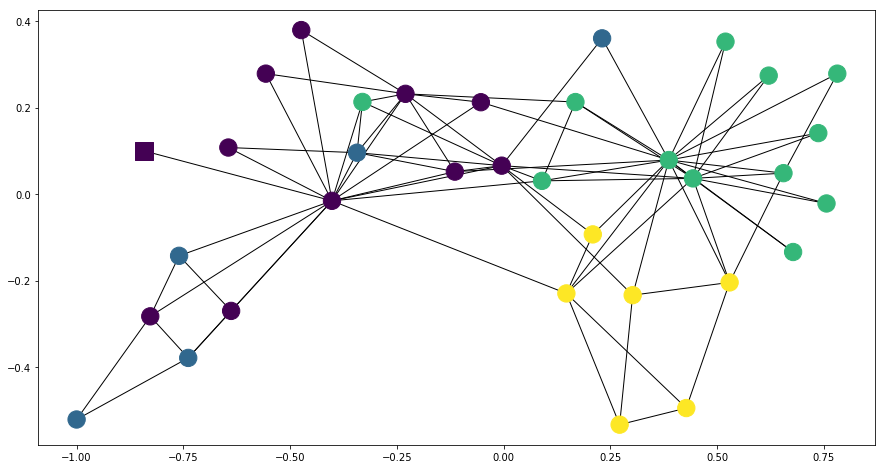

In [2]:
g = nx.read_graphml('D:/bigdata/Python/Graph Neural Net/R/karate.graphml')

m=list(nx.get_node_attributes(g , 'membership').values())
plt.figure(figsize=(15,8))
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos ,nodelist=['n11'],node_color=[m[0]], node_shape='s')
nx.draw_networkx_nodes(g, pos ,nodelist=['n'+str(i) for i in range(34) if i!=11],node_color=m[1:], node_shape='o')
nx.draw_networkx_edges(g,pos)
# Get important parameters of adjacency matrix
adj = nx.adj_matrix(g)
n_nodes = adj.shape[0]
adj_tilde = adj + np.identity(n=adj.shape[0], dtype=np.float32)
numpy_adj=adj_tilde-np.identity(n=adj.shape[0], dtype=np.float32)
d_tilde_diag = np.squeeze(np.sum(np.array(adj_tilde), axis=1))
d_tilde_inv_sqrt_diag = np.power(d_tilde_diag, -1/2, dtype=np.float32)
d_tilde_inv_sqrt = np.diag(d_tilde_inv_sqrt_diag)
adj_norm = np.dot(np.dot(d_tilde_inv_sqrt, adj_tilde), d_tilde_inv_sqrt)
adj_norm=adj_norm.astype(np.float32)
feat_x = np.identity(n=adj.shape[0])

In [3]:
# Semi-supervised
memberships = [m - 1 for m in nx.get_node_attributes(g, 'membership').values()]

nb_classes = len(set(memberships))
targets = np.array([memberships], dtype=np.int32).reshape(-1)
one_hot_targets = np.eye(4)[targets]

# Pick 3 from each class
labels_to_keep=[17,2,3,  4,6,5,  15,9,20,  27,24,31]

y_train = np.zeros(shape=one_hot_targets.shape,
                   dtype=np.float32)
y_test = one_hot_targets.copy()

train_mask = np.zeros(shape=(n_nodes,), dtype=np.bool)
test_mask = np.ones(shape=(n_nodes,), dtype=np.bool)

for l in labels_to_keep:
    y_train[l, :] = one_hot_targets[l, :]
    y_test[l, :] = np.zeros(shape=(nb_classes,))
    train_mask[l] = True
    test_mask[l] = False

In [4]:
class JKNet:
    def __init__(self, layer, n_nodes, f_dimension, nb_classes, initializer=tf.contrib.layers.xavier_initializer(uniform=False)):
        self.X = tf.placeholder('float32',shape=(n_nodes*f_dimension))
        self.y = tf.placeholder('float32', shape=(n_nodes, nb_classes))
        self.mask=tf.placeholder('float32')
        self.nodes=n_nodes
        self.output_dim = nb_classes
        self.layer = layer
        self.is_train=tf.placeholder(tf.bool)
        self.adj=tf.placeholder('float32',shape=(n_nodes, n_nodes))
        self.dropout=tf.placeholder(tf.float32)
        self.init=initializer
        
    def loss(self, lr, active=tf.nn.relu, optim=tf.train.AdamOptimizer, JK_Model='concat'):
        self.L=tf.identity(tf.reshape(self.X, [self.nodes, -1]))
        _layers= []
        for i in range(len(self.layer)):
            self.L=self.graph_conv(self.L, self.adj, self.layer[i], activation=active)
            self.L= tf.nn.dropout(self.L, self.dropout)
            _layers.append(self.L)
            
        if JK_Model=='concat':
            hypo= tf.concat(_layers, axis=1)

            
        elif JK_Model=='MaxPooling':
            hypo= tf.stack(_layers, axis=0)   
            hypo = tf.reduce_max(hypo, axis=0)

            
        elif JK_Model=='Bi-LSTM Attention':
            self.Attention=self.Bi_directional_lstm_attention(_layers)
            hypo=0
            for i in range(len(_layers)):
                hypo+=self.Attention[i]*_layers[i]

            
        elif JK_Model=='Only_GCN':
            hypo=self.L

        elif JK_Model=='Only_GAT':
            self.hidden_layer=tf.identity(self.L)
            for i, hidden_layer in enumerate(self.layer):
                self.hidden_layer = tf.layers.dense(self.hidden_layer, hidden_layer, kernel_initializer=self.init)
                self.coeffs = self.attn_coeffs_DGL(self.hidden_layer, self.adj)
                self.hidden_layer = tf.matmul(self.coeffs, self.hidden_layer) # [batch_size, num_nodes, num_nodes]  
                self.hidden_layer = active(self.hidden_layer)
                self.hidden_layer = tf.nn.dropout(self.hidden_layer, self.dropout)
            hypo=self.hidden_layer

        else:
            raise ValueError("You should assign JK_model")
        
        
        
        hypo=tf.matmul(self.adj, hypo)
        self.influence=self.Influence_x_y(11, hypo)
        self.hypothesis = tf.layers.dense(hypo, self.output_dim, activation=tf.nn.softmax, kernel_initializer=self.init)
        
        var   = tf.trainable_variables()     
        lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in var if 'bias' not in v.name ]) *  0.0005  
        
        self.cost=tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.hypothesis)+lossL2
        mask = tf.cast(self.mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        

        self.cost *= mask       
        self.cost=tf.reduce_mean(self.cost)
        
        self.optimizer = optim(learning_rate=lr)
        self.trains = self.optimizer.minimize(self.cost)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def graph_conv(self, _X, _A, output_dim, activation=tf.nn.relu):
        output = tf.layers.dense(_X, units=output_dim, kernel_initializer=self.init)
        output = tf.matmul(_A, output)
        output = activation(output)
        return output
    
    def Bi_directional_lstm_attention(self, Layer):
        l=[]
        for layer in Layer:
            l.append(tf.reshape(layer, [1,-1]))
        X=tf.stack(l, axis=1)
        
        lstm_fw_cell = tf.nn.rnn_cell.LSTMCell(num_units = self.layer[0], state_is_tuple = True)
        lstm_fw_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_fw_cell, output_keep_prob=self.dropout)
        
        lstm_bw_cell = tf.nn.rnn_cell.LSTMCell(num_units = self.layer[0], state_is_tuple = True)
        lstm_bw_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_bw_cell, output_keep_prob=self.dropout)
        
        outputs,_ = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell,lstm_bw_cell, X, dtype = tf.float32)

        outputs_fw = tf.reshape(outputs[0], [len(Layer),self.layer[0]])
        outputs_bw = tf.reshape(outputs[1], [len(Layer),self.layer[0]])
        outputs_concat = tf.concat([outputs_fw, outputs_bw], axis=1)
        concatenated=tf.layers.dense(outputs_concat, units=1, use_bias=True, kernel_initializer=self.init)
        s=tf.nn.softmax(tf.reshape(concatenated,[-1]))
        return s
                    
    def Influence_x_y(self, Node_x, hypo):
        abs_grad=tf.math.abs(tf.gradients(tf.reshape(hypo[Node_x], [-1]), self.X)[0])
        abs_grad=tf.reshape(abs_grad,[self.nodes,-1])
        jacobian=tf.reduce_sum(abs_grad,axis=1)
        Influence_of_Y_ON_X=jacobian/tf.reduce_sum(jacobian)
        return Influence_of_Y_ON_X
        
    def attn_coeffs_DGL(self, H, A):
        H=tf.matmul(A,H)
        logits = tf.layers.dense(H, self.nodes,activation=tf.nn.leaky_relu)
        zero_vec = -9e15*tf.ones_like(logits)
        attention = tf.where(A > 0, logits, zero_vec)
        coefs = tf.nn.softmax(attention, axis=1)
        return coefs
    
    def accuracy(self, X, Y, mask, adj):
        """Accuracy with masking."""
        preds, influence=self.sess.run([self.hypothesis, self.influence], feed_dict={self.X:X, self.y:Y, self.adj:adj,
                                                                              self.mask:mask, self.dropout:1})
        correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(Y, 1))
        accuracy_all = tf.cast(correct_prediction, tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        mask /= tf.reduce_mean(mask)
        accuracy_all *= mask
        return self.sess.run(tf.reduce_mean(accuracy_all)), influence
    
        
    
    def train(self, batch_xs, batch_ys, mask, avg_cost, adj):
        _, c = self.sess.run([self.trains, self.cost], feed_dict={self.X: batch_xs, self.y: batch_ys,  self.adj:adj,
                                                                  self.mask:mask, self.dropout:0.5})
        avg_cost += np.mean(c)
        return avg_cost
    



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [5]:
tf.reset_default_graph()
model=JKNet([16,16,16,16], 34, 34, 4)
model.loss(1e-2, active=tf.nn.relu, JK_Model='Only_GCN')
for epoch in range(5):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj = feat_x.reshape(-1),  y_train, np.array(adj_norm)
        avg_cost=model.train(batch_xs, batch_ys, train_mask, avg_cost/50, adj)
    train_acc, influe=model.accuracy(batch_xs, batch_ys, train_mask, adj)
    test_acc, _=model.accuracy(batch_xs, y_test, test_mask, adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch: 0001 cost= 1.3245 train_acc:  0.41666666   test_acc:  0.40909088
Epoch: 0002 cost= 1.05236 train_acc:  0.75   test_acc:  0.5454545
Epoch: 0003 cost= 1.0059 train_acc:  1.0   test_acc:  0.6818182
Epoch: 0004 cost= 0.8984 train_acc:  0.9166666   test_acc:  0.77272725
Epoch: 0005 cost= 1.09423 train_acc:  1.0   test_acc:  0.7272727


# Influence distribution of 4-Layer GCN

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


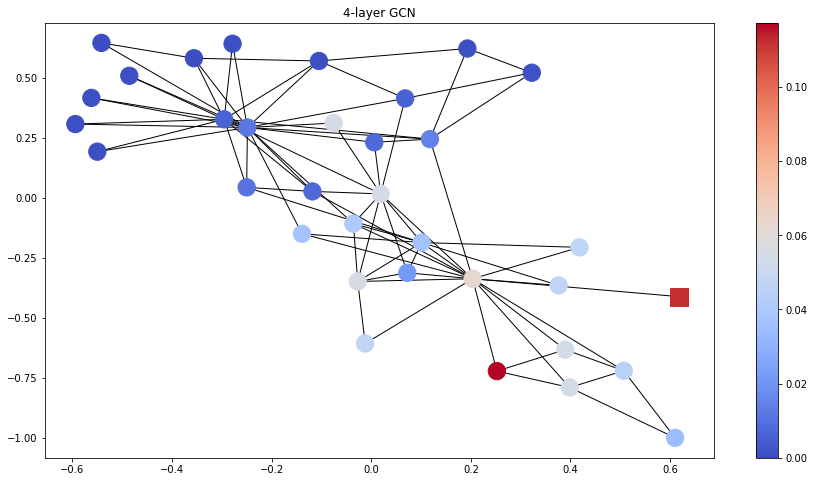

In [6]:
plt.figure(figsize=(15,8))
plt.title('4-layer GCN')
pos = nx.spring_layout(g)
cmap = plt.cm.coolwarm
nx.draw_networkx_nodes(g, pos ,nodelist=['n11'],node_color=[influe[0]], node_shape='s',  cmap=cmap,vmin=0, vmax=influe.max())
nx.draw_networkx_nodes(g, pos ,nodelist=['n'+str(i) for i in range(34) if i!=11],node_color=influe[1:], node_shape='o', cmap=cmap, vmin=0, vmax=influe.max())
nx.draw_networkx_edges(g,pos)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=influe.max()))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()

In [7]:
tf.reset_default_graph()
model=JKNet([16,16,16,16], 34, 34, 4)
model.loss(1e-2, active=tf.nn.relu, JK_Model='Only_GAT')
for epoch in range(5):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj = feat_x.reshape(-1),  y_train, np.array(adj_norm)
        avg_cost=model.train(batch_xs, batch_ys, train_mask, avg_cost/50, adj)
    train_acc, influe=model.accuracy(batch_xs, batch_ys, train_mask, adj)
    test_acc, _=model.accuracy(batch_xs, y_test, test_mask, adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

Epoch: 0001 cost= 1.3985 train_acc:  0.25   test_acc:  0.36363634
Epoch: 0002 cost= 1.36889 train_acc:  0.41666666   test_acc:  0.36363634
Epoch: 0003 cost= 1.37062 train_acc:  0.5   test_acc:  0.45454544
Epoch: 0004 cost= 1.37434 train_acc:  0.41666666   test_acc:  0.36363634
Epoch: 0005 cost= 1.33081 train_acc:  0.41666666   test_acc:  0.36363634


# Influence distribution of 4-Layer GAT

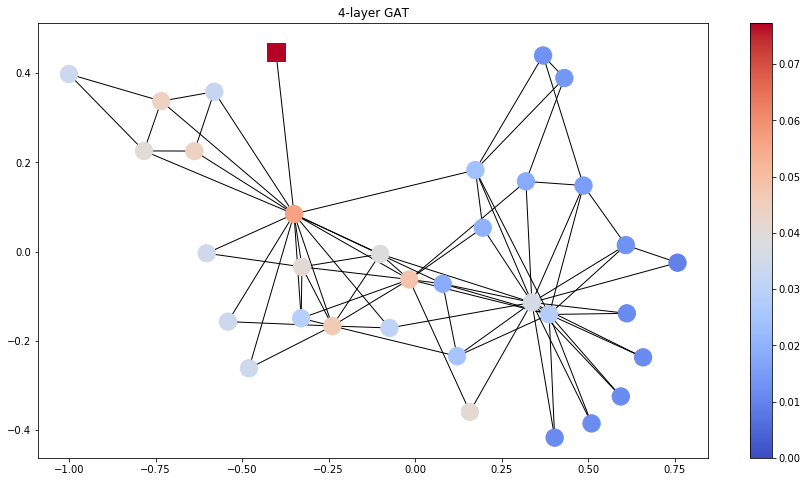

In [8]:
plt.figure(figsize=(15,8))
plt.title('4-layer GAT')
pos = nx.spring_layout(g)
cmap = plt.cm.coolwarm
nx.draw_networkx_nodes(g, pos ,nodelist=['n11'],node_color=[influe[0]], node_shape='s',  cmap=cmap,vmin=0, vmax=influe.max())
nx.draw_networkx_nodes(g, pos ,nodelist=['n'+str(i) for i in range(34) if i!=11],node_color=influe[1:], node_shape='o', cmap=cmap, vmin=0, vmax=influe.max())
nx.draw_networkx_edges(g,pos)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=influe.max()))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()

In [9]:
tf.reset_default_graph()
model=JKNet([16,16,16,16], 34, 34, 4)
model.loss(1e-2, active=tf.nn.relu, JK_Model='concat')
for epoch in range(5):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj = feat_x.reshape(-1),  y_train, np.array(adj_norm)
        avg_cost=model.train(batch_xs, batch_ys, train_mask, avg_cost/50, adj)
    train_acc, influe=model.accuracy(batch_xs, batch_ys, train_mask, adj)
    test_acc, _=model.accuracy(batch_xs, y_test, test_mask, adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

Epoch: 0001 cost= 0.9282 train_acc:  1.0   test_acc:  0.9090908
Epoch: 0002 cost= 0.82147 train_acc:  1.0   test_acc:  0.9090908
Epoch: 0003 cost= 0.83026 train_acc:  1.0   test_acc:  0.9090908
Epoch: 0004 cost= 0.88604 train_acc:  1.0   test_acc:  0.9090908
Epoch: 0005 cost= 0.84369 train_acc:  1.0   test_acc:  0.95454544


# Influence distribution of 4-Layer CONCATENATION

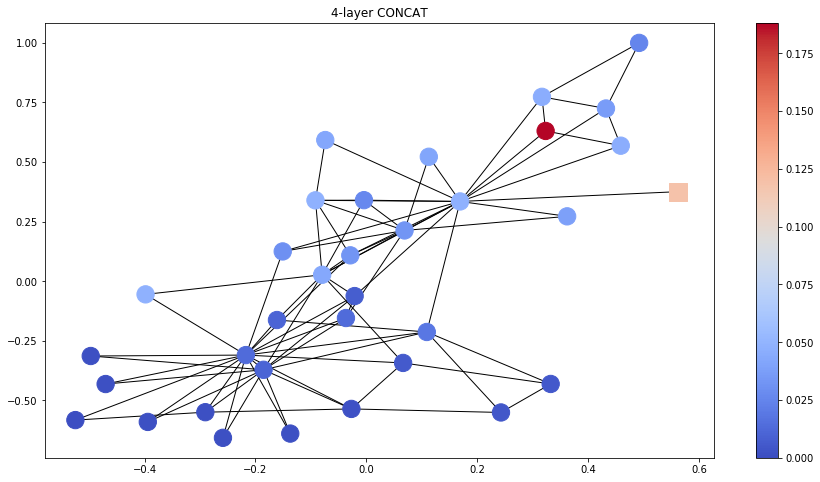

In [10]:
plt.figure(figsize=(15,8))
plt.title('4-layer CONCAT')
pos = nx.spring_layout(g)
cmap = plt.cm.coolwarm
nx.draw_networkx_nodes(g, pos ,nodelist=['n11'],node_color=[influe[0]], node_shape='s',  cmap=cmap,vmin=0, vmax=influe.max())
nx.draw_networkx_nodes(g, pos ,nodelist=['n'+str(i) for i in range(34) if i!=11],node_color=influe[1:], node_shape='o', cmap=cmap, vmin=0, vmax=influe.max())
nx.draw_networkx_edges(g,pos)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=influe.max()))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()

In [11]:
tf.reset_default_graph()
model=JKNet([16,16,16,16], 34, 34, 4)
model.loss(1e-2, active=tf.nn.relu, JK_Model='MaxPooling')
for epoch in range(5):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj = feat_x.reshape(-1),  y_train, np.array(adj_norm)
        avg_cost=model.train(batch_xs, batch_ys, train_mask, avg_cost/50, adj)
    train_acc, influe=model.accuracy(batch_xs, batch_ys, train_mask, adj)
    test_acc, _=model.accuracy(batch_xs, y_test, test_mask, adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch: 0001 cost= 0.98986 train_acc:  1.0   test_acc:  0.7272727
Epoch: 0002 cost= 0.83257 train_acc:  1.0   test_acc:  0.95454544
Epoch: 0003 cost= 0.81961 train_acc:  1.0   test_acc:  0.95454544
Epoch: 0004 cost= 0.81141 train_acc:  1.0   test_acc:  0.95454544
Epoch: 0005 cost= 0.80572 train_acc:  1.0   test_acc:  1.0


# Influence distribution of 4-Layer MAXPOOLING

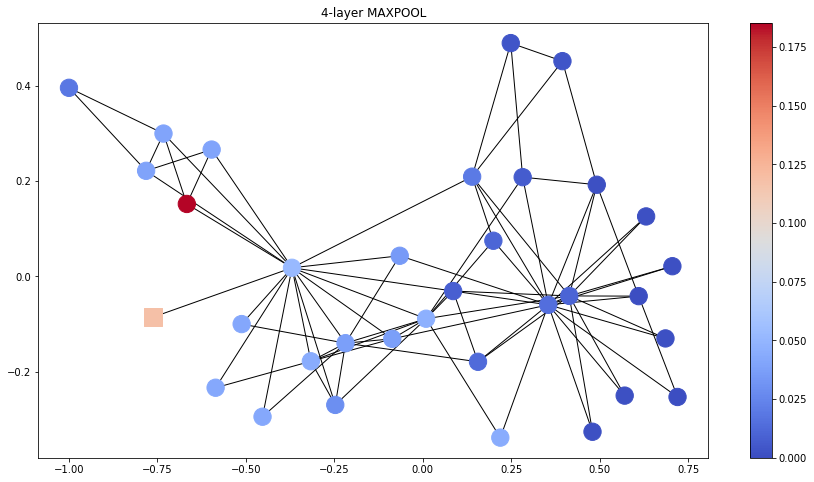

In [12]:
plt.figure(figsize=(15,8))
plt.title('4-layer MAXPOOL')
pos = nx.spring_layout(g)
cmap = plt.cm.coolwarm
nx.draw_networkx_nodes(g, pos ,nodelist=['n11'],node_color=[influe[0]], node_shape='s',  cmap=cmap,vmin=0, vmax=influe.max())
nx.draw_networkx_nodes(g, pos ,nodelist=['n'+str(i) for i in range(34) if i!=11],node_color=influe[1:], node_shape='o', cmap=cmap, vmin=0, vmax=influe.max())
nx.draw_networkx_edges(g,pos)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=influe.max()))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()

In [13]:
tf.reset_default_graph()
model=JKNet([16,16,16,16], 34, 34, 4)
model.loss(1e-2, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
for epoch in range(5):
    avg_cost=0
    for i in range(50):
        batch_xs, batch_ys, adj = feat_x.reshape(-1),  y_train, np.array(adj_norm)
        avg_cost=model.train(batch_xs, batch_ys, train_mask, avg_cost/50, adj)
    train_acc, influe=model.accuracy(batch_xs, batch_ys, train_mask, adj)
    test_acc, _=model.accuracy(batch_xs, y_test, test_mask, adj)
    print('Epoch:','%04d' %(epoch+1),'cost=', np.round(avg_cost,5),'train_acc: ',train_acc, '  test_acc: ',test_acc)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Epoch: 0001 cost= 1.10196 train_acc:  0.9166666   test_acc:  0.5454545
Epoch: 0002 cost= 0.88588 train_acc:  1.0   test_acc:  0.9090908
Epoch: 0003 cost= 0.8806 train_acc:  1.0   test_acc:  1.0
Epoch: 0004 cost= 0.87165 train_acc:  1.0   test_acc:  1.0
Epoch: 0005 cost= 0.83702 train_acc:  1.0   test_acc:  1.0


# Influence distribution of 4-Layer BI-LSTM ATTENTION

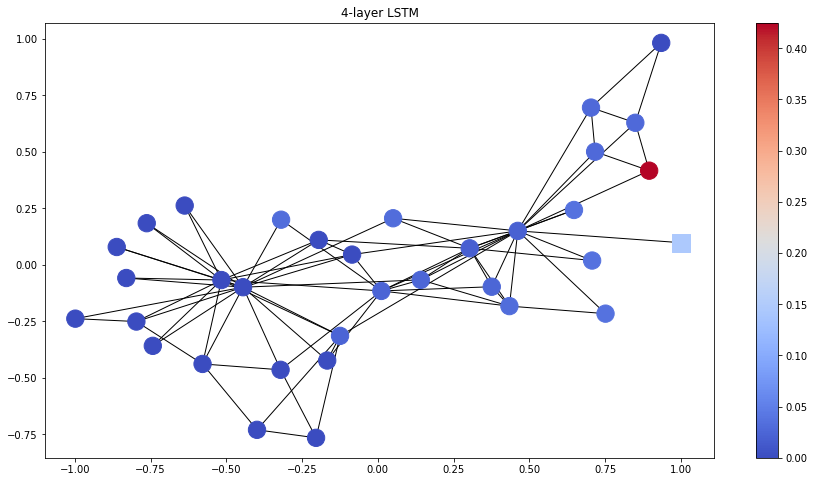

In [14]:
plt.figure(figsize=(15,8))
plt.title('4-layer LSTM')
pos = nx.spring_layout(g)
cmap = plt.cm.coolwarm
nx.draw_networkx_nodes(g, pos ,nodelist=['n11'],node_color=[influe[0]], node_shape='s',  cmap=cmap,vmin=0, vmax=influe.max())
nx.draw_networkx_nodes(g, pos ,nodelist=['n'+str(i) for i in range(34) if i!=11],node_color=influe[1:], node_shape='o', cmap=cmap, vmin=0, vmax=influe.max())
nx.draw_networkx_edges(g,pos)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=influe.max()))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()

# Cora Datasets

In [15]:
def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)


def load_data(dataset_str):
    """
    Loads input data from gcn/data directory

    ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances
        (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
    ind.dataset_str.y => the one-hot labels of the labeled training instances as numpy.ndarray object;
    ind.dataset_str.ty => the one-hot labels of the test instances as numpy.ndarray object;
    ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
    ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]} as collections.defaultdict
        object;
    ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting as list object.

    All objects above must be saved using python pickle module.

    :param dataset_str: Dataset name
    :return: All data input files loaded (as well the training/test data).
    """
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("D:/bigdata/Python/Graph Neural Net/Graph-neural-networks-master/tutorials/data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("D:/bigdata/Python/Graph Neural Net/Graph-neural-networks-master/tutorials/data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)
    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    idx_test = np.random.choice(2708, int(2708*0.2), replace=False)
    without_test=np.array([i for i in range(2708) if i not in idx_test ])
    idx_train = without_test[np.random.choice(np.arange(len(without_test)),int(2708*0.6), replace=False)]
    idx_val = np.array([i for i in range(2708) if i not in idx_test if i not in idx_train])

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    return adj, features, np.array(y_train), np.array(y_val), np.array(y_test), np.array(train_mask), np.array(val_mask), np.array(test_mask), graph


def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx


def preprocess_features(features):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return sparse_to_tuple(features)


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)


def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary."""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i] for i in range(len(support))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict


def chebyshev_polynomials(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrices (tuple representation)."""
    print("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    t_k.append(sp.eye(adj.shape[0]))
    t_k.append(scaled_laplacian)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    return sparse_to_tuple(t_k)


In [16]:
adj_cora, features_cora, y_train_cora, y_val_cora, y_test_cora, train_mask_cora, val_mask_cora, test_mask_cora, cora_graph = load_data('cora')

In [17]:
features_cora=np.array(features_cora.todense())

In [18]:
adj_norm_cora = normalize_adj(adj_cora + sp.eye(adj_cora.shape[0]))
adj_norm_cora=adj_norm_cora.todense()
adj_norm_cora=np.array(adj_norm_cora.astype(np.float32))

In [19]:
print('feature shape: ',features_cora.shape)
print('adj_norm_cora shape: ',adj_norm_cora.shape)
print('y_train_cora shape: ',y_train_cora.shape)

feature shape:  (2708, 1433)
adj_norm_cora shape:  (2708, 2708)
y_train_cora shape:  (2708, 7)


# GCN

In [20]:
tf.reset_default_graph()
model_cora=JKNet([32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GCN')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.8965496
Epoch: 0002 train_acc:  0.93657404
Epoch: 0003 train_acc:  0.95012075
Epoch: 0004 train_acc:  0.9562784
Epoch: 0005 train_acc:  0.96120447
Test_acc:  0.8909425


In [21]:
tf.reset_default_graph()
model_cora=JKNet([32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GCN')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.7980278
Epoch: 0002 train_acc:  0.88115555
Epoch: 0003 train_acc:  0.93657404
Epoch: 0004 train_acc:  0.9464262
Epoch: 0005 train_acc:  0.949505
Test_acc:  0.8927909


In [22]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GCN')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.79125446
Epoch: 0002 train_acc:  0.86021966
Epoch: 0003 train_acc:  0.92364305
Epoch: 0004 train_acc:  0.9334952
Epoch: 0005 train_acc:  0.9353425
Test_acc:  0.8872456


In [23]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32, 32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GCN')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.6373142
Epoch: 0002 train_acc:  0.7998751
Epoch: 0003 train_acc:  0.86391425
Epoch: 0004 train_acc:  0.9217957
Epoch: 0005 train_acc:  0.9291849
Test_acc:  0.8872456


### Best performance GCN Layer : 2
### Test Acc : 89.2%

# GAT

In [24]:
tf.reset_default_graph()
model_cora=JKNet([32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GAT')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.8331262
Epoch: 0002 train_acc:  0.93287945
Epoch: 0003 train_acc:  0.949505
Epoch: 0004 train_acc:  0.9568941
Epoch: 0005 train_acc:  0.9587414
Test_acc:  0.88354874


In [25]:
tf.reset_default_graph()
model_cora=JKNet([32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GAT')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.6847278
Epoch: 0002 train_acc:  0.8706876
Epoch: 0003 train_acc:  0.8866974
Epoch: 0004 train_acc:  0.9261061
Epoch: 0005 train_acc:  0.9396528
Test_acc:  0.88354874


In [26]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GAT')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.4316501
Epoch: 0002 train_acc:  0.57389086
Epoch: 0003 train_acc:  0.794949
Epoch: 0004 train_acc:  0.8060327
Epoch: 0005 train_acc:  0.8121903
Test_acc:  0.72643214


In [27]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Only_GAT')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.4107142
Epoch: 0002 train_acc:  0.46798
Epoch: 0003 train_acc:  0.6231517
Epoch: 0004 train_acc:  0.6520925
Epoch: 0005 train_acc:  0.6613289
Test_acc:  0.5711643


### Best performance GAT Layer : 1,2
### Test Acc : 88.3%

# Concat

In [28]:
tf.reset_default_graph()
model_cora=JKNet([32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='concat')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.8706876
Epoch: 0002 train_acc:  0.9051702
Epoch: 0003 train_acc:  0.95381534
Epoch: 0004 train_acc:  0.9599729
Epoch: 0005 train_acc:  0.9605887
Test_acc:  0.8872456


In [29]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='concat')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.810343
Epoch: 0002 train_acc:  0.9100963
Epoch: 0003 train_acc:  0.9470419
Epoch: 0004 train_acc:  0.9464262
Epoch: 0005 train_acc:  0.9568941
Test_acc:  0.88354874


In [30]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='concat')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.8423626
Epoch: 0002 train_acc:  0.93287945
Epoch: 0003 train_acc:  0.9433474
Epoch: 0004 train_acc:  0.9464262
Epoch: 0005 train_acc:  0.949505
Test_acc:  0.88539714


In [31]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='concat')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.80110663
Epoch: 0002 train_acc:  0.9267218
Epoch: 0003 train_acc:  0.9390371
Epoch: 0004 train_acc:  0.94519466
Epoch: 0005 train_acc:  0.949505
Test_acc:  0.8909425


In [32]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='concat')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.8405153
Epoch: 0002 train_acc:  0.93287945
Epoch: 0003 train_acc:  0.9384213
Epoch: 0004 train_acc:  0.9433474
Epoch: 0005 train_acc:  0.94888926
Test_acc:  0.8946394


In [33]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='concat')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.7943333
Epoch: 0002 train_acc:  0.92487454
Epoch: 0003 train_acc:  0.94211584
Epoch: 0004 train_acc:  0.9464262
Epoch: 0005 train_acc:  0.9464262
Test_acc:  0.8964878


### Best performance Concatenate Layer : 7
### Test Acc : 89.6%

# MaxPooling

In [34]:
tf.reset_default_graph()
model_cora=JKNet([32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='MaxPooling')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.7598506
Epoch: 0002 train_acc:  0.8719191
Epoch: 0003 train_acc:  0.94519466
Epoch: 0004 train_acc:  0.95381534
Epoch: 0005 train_acc:  0.9562784
Test_acc:  0.89094245


In [35]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='MaxPooling')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.8676088
Epoch: 0002 train_acc:  0.9008599
Epoch: 0003 train_acc:  0.94519466
Epoch: 0004 train_acc:  0.9507365
Epoch: 0005 train_acc:  0.94888926
Test_acc:  0.8964878


In [36]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='MaxPooling')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.75492454
Epoch: 0002 train_acc:  0.9217957
Epoch: 0003 train_acc:  0.9396528
Epoch: 0004 train_acc:  0.9470419
Epoch: 0005 train_acc:  0.95012075
Test_acc:  0.8909425


In [37]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='MaxPooling')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.79618055
Epoch: 0002 train_acc:  0.88238704
Epoch: 0003 train_acc:  0.9322637
Epoch: 0004 train_acc:  0.9347267
Epoch: 0005 train_acc:  0.9482735
Test_acc:  0.88539726


In [38]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='MaxPooling')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.8158849
Epoch: 0002 train_acc:  0.93164796
Epoch: 0003 train_acc:  0.9402686
Epoch: 0004 train_acc:  0.949505
Epoch: 0005 train_acc:  0.9476577
Test_acc:  0.90018463


In [39]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='MaxPooling')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.8614512
Epoch: 0002 train_acc:  0.9051702
Epoch: 0003 train_acc:  0.9402686
Epoch: 0004 train_acc:  0.9464262
Epoch: 0005 train_acc:  0.9482735
Test_acc:  0.8835488


### Best performance MAXPOOLING Layer : 6
### Test Acc : 90.0%

# Bi-LSTM

In [41]:
tf.reset_default_graph()
model_cora=JKNet([32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.8312789
Epoch: 0002 train_acc:  0.93595827
Epoch: 0003 train_acc:  0.9507365
Epoch: 0004 train_acc:  0.9599729
Epoch: 0005 train_acc:  0.9618202
Test_acc:  0.8909425


In [42]:
tf.reset_default_graph()
model_cora=JKNet([32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.79741204
Epoch: 0002 train_acc:  0.86021966
Epoch: 0003 train_acc:  0.8793082
Epoch: 0004 train_acc:  0.9427316
Epoch: 0005 train_acc:  0.951968
Test_acc:  0.8909425


In [43]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.84790444
Epoch: 0002 train_acc:  0.866993
Epoch: 0003 train_acc:  0.93595827
Epoch: 0004 train_acc:  0.94519466
Epoch: 0005 train_acc:  0.949505
Test_acc:  0.8909425


In [44]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.83989954
Epoch: 0002 train_acc:  0.9137909
Epoch: 0003 train_acc:  0.94088435
Epoch: 0004 train_acc:  0.95443106
Epoch: 0005 train_acc:  0.9587414
Test_acc:  0.89463943


In [45]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.7697028
Epoch: 0002 train_acc:  0.9193327
Epoch: 0003 train_acc:  0.9390371
Epoch: 0004 train_acc:  0.9513523
Epoch: 0005 train_acc:  0.95935714
Test_acc:  0.8909425


In [46]:
tf.reset_default_graph()
model_cora=JKNet([32,32,32,32,32,32], 2708, 1433, 7)
model_cora.loss(5e-3, active=tf.nn.relu, JK_Model='Bi-LSTM Attention')
for epoch in range(5):
    avg_cost=0
    for i in range(40):
        batch_xs, batch_ys, adj=features_cora.reshape(-1),  y_train_cora, adj_norm_cora
        avg_cost=model_cora.train(batch_xs, batch_ys, train_mask_cora, avg_cost/100, adj)
    train_acc, _=model_cora.accuracy(batch_xs, batch_ys, train_mask_cora, adj)
    print('Epoch:','%04d' %(epoch+1),'train_acc: ',train_acc)
test_acc, _=model_cora.accuracy(batch_xs, y_test_cora, test_mask_cora, adj)
print('Test_acc: ',test_acc)

Epoch: 0001 train_acc:  0.5825115
Epoch: 0002 train_acc:  0.7980278
Epoch: 0003 train_acc:  0.81280607
Epoch: 0004 train_acc:  0.8866974
Epoch: 0005 train_acc:  0.9137909
Test_acc:  0.87245816


### Best performance LSTM Layer : 4
### Test Acc : 89.4%